In [4]:
!pip install opencv-python --quiet


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


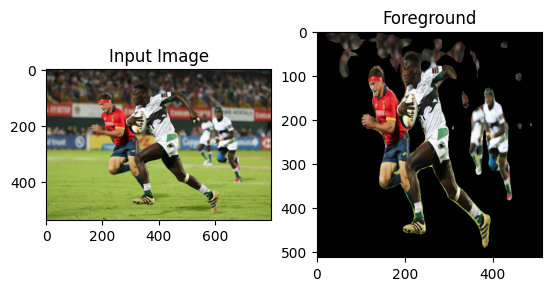

In [11]:
import numpy as np
from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F

def extract_foreground(image_path):

    # Load DeepLabv3 model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    model.eval()

    # Load input image
    input_image = Image.open(image_path)

    # Resize input image to a specific size
    image_size = (512, 512)  # specify desired image size
    input_image = input_image.resize(image_size)

    # Convert input image to RGB format
    input_image = input_image.convert("RGB")

    # Preprocess input image
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        output_mask = model(input_batch)['out']
    output_mask = F.interpolate(output_mask, size=image_size, mode='bilinear', align_corners=False)
    output_mask = torch.argmax(output_mask, dim=1).squeeze().detach().cpu().numpy()

    # Create binary mask from output mask
    binary_mask = np.zeros_like(output_mask)
    binary_mask[output_mask == 15] = 1  # specify the class index for the foreground in DeepLabv3 (here, class index 15)

    # Overlay foreground on blank canvas
    foreground = np.uint8(input_image * binary_mask[..., np.newaxis])

    return foreground


image_path = "/content/kvcxkx9jenixi0o606737f7302be.jpg"
foreground = extract_foreground(image_path)

# Visualize input image without background
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path))
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(foreground)
plt.title("Foreground")
plt.show()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


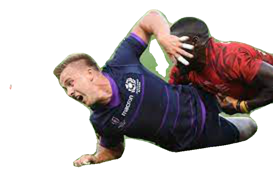

In [23]:
from PIL import Image
from torchvision import transforms
import torch
from torch.nn import functional as F
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def extract_foreground(image_path):

    # Load DeepLabv3 model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    model.eval()

    # Load input image
    input_image = Image.open(image_path)

    # Get original image size
    original_size = input_image.size

    # Resize input image to a specific size
    image_size = (512, 512)  # specify desired image size
    input_image = input_image.resize(image_size)

    # Convert input image to RGB format
    input_image = input_image.convert("RGB")

    # Preprocess input image
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        output_mask = model(input_batch)['out']
    output_mask = F.interpolate(output_mask, size=image_size, mode='bilinear', align_corners=False)
    output_mask = torch.argmax(output_mask, dim=1).squeeze().detach().cpu().numpy()

    # Create binary mask from output mask
    binary_mask = np.zeros_like(output_mask)
    binary_mask[output_mask == 15] = 1  # specify the class index for the foreground in DeepLabv3 (here, class index 15)

    # Overlay foreground on white canvas
    white_background = Image.new("RGB", input_image.size, (255, 255, 255))  # create a white canvas
    alpha = Image.fromarray(np.uint8(binary_mask * 255), mode="L")  # create an alpha channel from the binary mask
    foreground = Image.composite(input_image, white_background, alpha)

    # Resize foreground to original image size
    foreground = foreground.resize(original_size)

    return foreground

# Example usage
image_path = "/content/download (1).jpg"
foreground= extract_foreground(image_path)

# Save foreground as PNG
#foreground.save("foreground.png")

# Visualize white background
foreground.show()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


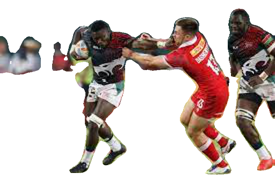

In [24]:
# Example usage
image_path = "/content/download.jpg"
foreground= extract_foreground(image_path)


foreground.show()


In [26]:
!pip install streamlit pillow torchvision torch --quiet

In [73]:

%%writefile app.py
import streamlit as st

# Streamlit app

from PIL import Image
from torchvision import transforms
import torch
from torch.nn import functional as F
import numpy as np
import warnings
import io
warnings.filterwarnings('ignore')

def extract_foreground(image_path):

    # Load DeepLabv3 model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    model.eval()

    # Load input image
    input_image = Image.open(image_path)

    # Get original image size
    original_size = input_image.size

    # Resize input image to a specific size
    image_size = (512, 512)  # specify desired image size
    input_image = input_image.resize(image_size)

    # Convert input image to RGB format
    input_image = input_image.convert("RGB")

    # Preprocess input image
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        output_mask = model(input_batch)['out']
    output_mask = F.interpolate(output_mask, size=image_size, mode='bilinear', align_corners=False)
    output_mask = torch.argmax(output_mask, dim=1).squeeze().detach().cpu().numpy()

    # Create binary mask from output mask
    binary_mask = np.zeros_like(output_mask)
    binary_mask[output_mask == 15] = 1  # specify the class index for the foreground in DeepLabv3 (here, class index 15)

    # Overlay foreground on white canvas
    white_background = Image.new("RGB", input_image.size, (255, 255, 255))  # create a white canvas
    alpha = Image.fromarray(np.uint8(binary_mask * 255), mode="L")  # create an alpha channel from the binary mask
    foreground = Image.composite(input_image, white_background, alpha)

    # Resize foreground to original image size
    foreground = foreground.resize(original_size)

    return foreground

# Define CSS styles
PAGE_STYLE = """
<style>
body {
    font-family: Arial, sans-serif;
    background-color: #f8f9fa;
    margin: 0;
    padding: 0;
}

.container {
    max-width: 800px;
    margin: 0 auto;
    padding: 20px;
}

.title {
    font-size: 24px;
    font-weight: bold;
    margin-bottom: 20px;
}

.image {
    max-width: 100%;
    height: auto;
    margin-bottom: 20px;
}

.downloadButton {
    background-color: #007bff;
    color: #fff;
    padding: 12px 20px;
    border: none;
    cursor: pointer;
    font-size: 16px;
    margin-top: 16px;
}
.downloadButton:hover {
    background-color: #0056b3;
}
</style>
"""

# Create Streamlit app
st.title("Foreground Extraction")

# Upload image
uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width='auto')

    # Extract foreground
    extracted_foreground = extract_foreground(uploaded_file)
    st.image(extracted_foreground, caption="Extracted Foreground", use_column_width='auto')

    # Add download button for extracted foreground
    download_buffer = io.BytesIO()
    extracted_foreground.save(download_buffer, format='PNG')  # Change format to PNG
    download_button_str = f"Download Extracted Foreground"
    st.download_button(download_button_str, download_buffer.getvalue(), file_name='extracted_foreground.png')  # Change file extension to .png


Overwriting app.py


In [30]:
!pip install pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [64]:

from pyngrok import ngrok

ngrok.set_auth_token("2LArVCZnMmuPMV0uYjEx4zAOSpx_6AiMAuvnRpVMQxFzSkvaE") 


!nohup streamlit run app.py --server.port 80 &
url = ngrok.connect(port = '80')
print(url)
     

INFO:pyngrok.process:Updating authtoken for default "config_path" of "ngrok_path": /usr/local/lib/python3.9/dist-packages/pyngrok/bin/ngrok
2023-04-11 15:19:37.490 Updating authtoken for default "config_path" of "ngrok_path": /usr/local/lib/python3.9/dist-packages/pyngrok/bin/ngrok


nohup: appending output to 'nohup.out'


INFO:pyngrok.ngrok:Opening tunnel named: http-80-dd6d08b6-2625-4c40-be4c-d2440ba8b43c
2023-04-11 15:19:37.911 Opening tunnel named: http-80-dd6d08b6-2625-4c40-be4c-d2440ba8b43c
INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:38+0000 lvl=info msg="no configuration paths supplied"
2023-04-11 15:19:38.215 t=2023-04-11T15:19:38+0000 lvl=info msg="no configuration paths supplied"
INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:38+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
2023-04-11 15:19:38.227 t=2023-04-11T15:19:38+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:38+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil
2023-04-11 15:19:38.240 t=2023-04-11T15:19:38+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil
INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:38+0000 lvl=info msg="starting web service" obj=web addr

NgrokTunnel: "http://a4b8-35-194-203-172.ngrok-free.app" -> "http://localhost:80"


INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:39+0000 lvl=info msg="started tunnel" obj=tunnels name=http-80-dd6d08b6-2625-4c40-be4c-d2440ba8b43c addr=http://localhost:80 url=https://a4b8-35-194-203-172.ngrok-free.app
2023-04-11 15:19:39.287 t=2023-04-11T15:19:39+0000 lvl=info msg="started tunnel" obj=tunnels name=http-80-dd6d08b6-2625-4c40-be4c-d2440ba8b43c addr=http://localhost:80 url=https://a4b8-35-194-203-172.ngrok-free.app
INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:39+0000 lvl=info msg=end pg=/api/tunnels id=1c16cd5f6ba0c510 status=201 dur=395.06121ms
2023-04-11 15:19:39.291 t=2023-04-11T15:19:39+0000 lvl=info msg=end pg=/api/tunnels id=1c16cd5f6ba0c510 status=201 dur=395.06121ms
INFO:pyngrok.process.ngrok:t=2023-04-11T15:19:39+0000 lvl=info msg=start pg="/api/tunnels/http-80-dd6d08b6-2625-4c40-be4c-d2440ba8b43c (http)" id=e6809dd8483d3529
2023-04-11 15:19:39.298 t=2023-04-11T15:19:39+0000 lvl=info msg=start pg="/api/tunnels/http-80-dd6d08b6-2625-4c40-be4c-d2440ba8b43c (http)"

In [61]:
ngrok.kill()

INFO:pyngrok.process:Killing ngrok process: 32434
2023-04-11 15:18:30.845 Killing ngrok process: 32434
